In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import hmean
from scipy.stats import gmean
from scipy import interpolate
import math
import glob

#Apod import
from scipy.signal import hamming
from scipy.signal import blackman
from scipy.signal import hann
from scipy.signal import kaiser

pi = np.pi

/home/jscigliuto/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jscigliuto/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


8.649114805741864e-05
0.0001300048717690253
0.00011736929645951244
0.00020386044451693104
0.00024737416822853773
0.0003338653162859564


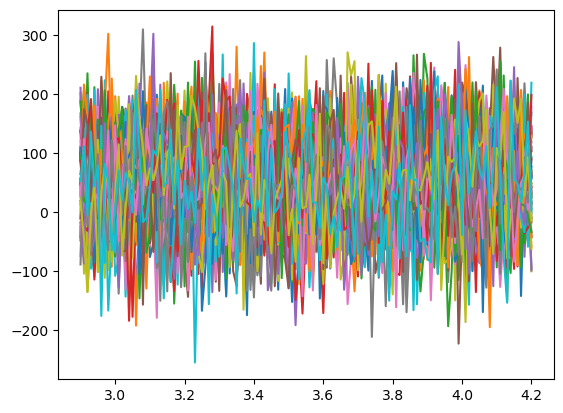

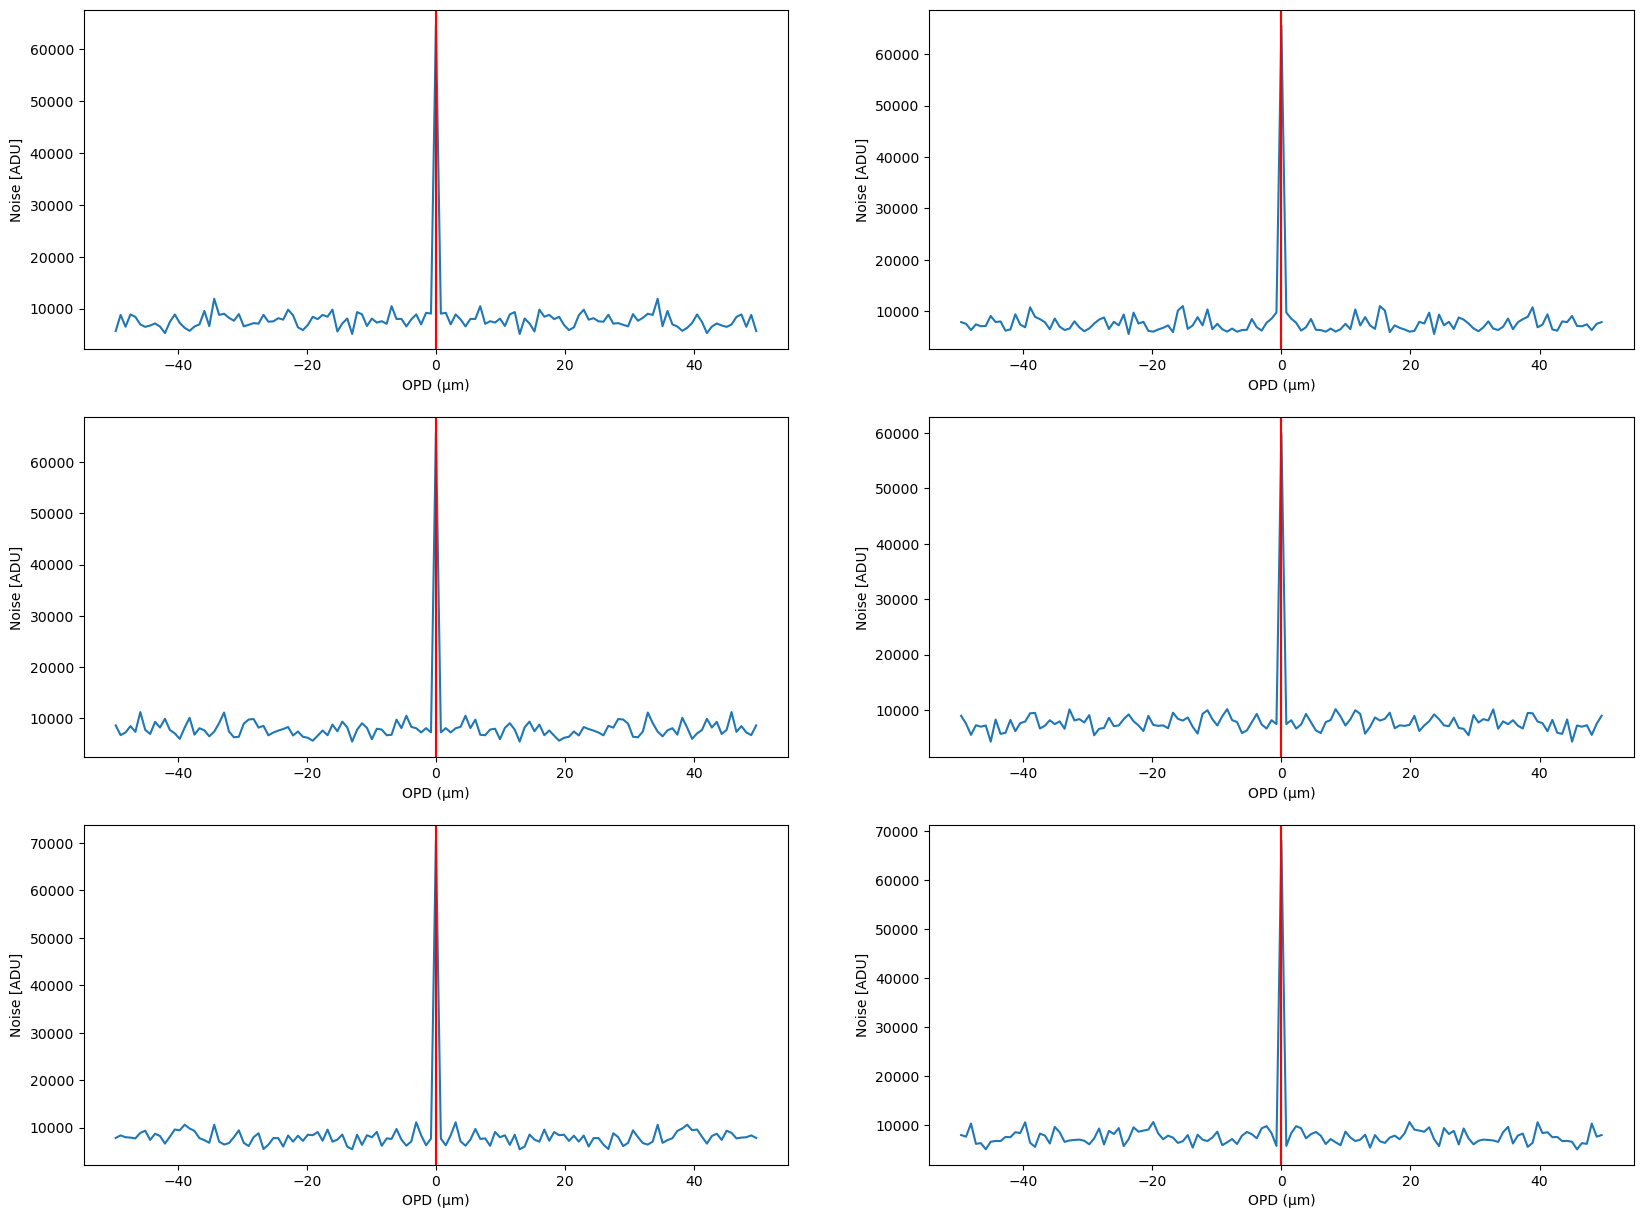

In [104]:
#Beta Pic b 
offset_RA = 281.6
offset_Dec = 452.8
R = 0.0017664150216057275
contrast = 0.0007914035074073295
path = '/store/projects/MATISSE/jscigliuto/betapicb_frames_corrected/2022-11-09T050425_OB1_exp2_frame2_planet_bin.fits'

def mas2rad(x):
    return x * (pi/180) * (1/3600000)

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

lam = np.arange(2.9, 4.2, 0.01) #µm
num_noises = 10
cf_noisy = np.zeros((num_noises,6,lam.size))
noise_lvl_phot = 50
noise_lvl_bg = 75

hdul = fits.open(path) 
u = hdul['OI_VIS'].data['ucoord']
v = hdul['OI_VIS'].data['vcoord']

for iB in range(6):
    for iN in range(num_noises):
        # Correlated flux     
        cf = contrast + R*np.exp(2j * pi * (offset_RA*u[iB] + offset_Dec*v[iB]) / lam)
        # Add background noise
        cf += np.random.normal(0, noise_lvl_bg, len(lam))
        # Add photon noise
        cf += np.random.poisson(noise_lvl_phot, len(lam))
        plt.plot(lam,cf)
        
        #TF
        cf_fft = np.fft.fftshift(np.fft.fft(cf))
        module = np.abs(cf_fft)

        #plt.plot(lam, module)

        cf_noisy[iN,iB] = module

        OPD = np.fft.fftshift(np.fft.fftfreq(lam.size, 0.01))
        fft_sum = np.sum(cf_noisy, axis=0)

fig, ax = plt.subplots(3,2, figsize=(20,15))
ax_flat = ax.ravel()

for iB in range(6):
    ax_flat[iB].plot(OPD, fft_sum[iB,:])
    ax_flat[iB].set_xlabel("OPD (µm)")
    ax_flat[iB].set_ylabel("Noise [ADU]") 


(140,)
2048
(140,)
2048
(140,)
2048
(140,)
2048
(140,)
2048
(140,)
2048
[-1.0377383044514337, 0.0, -1.0377383044514337, -1.0377383044514337, 0.0, 0.0]


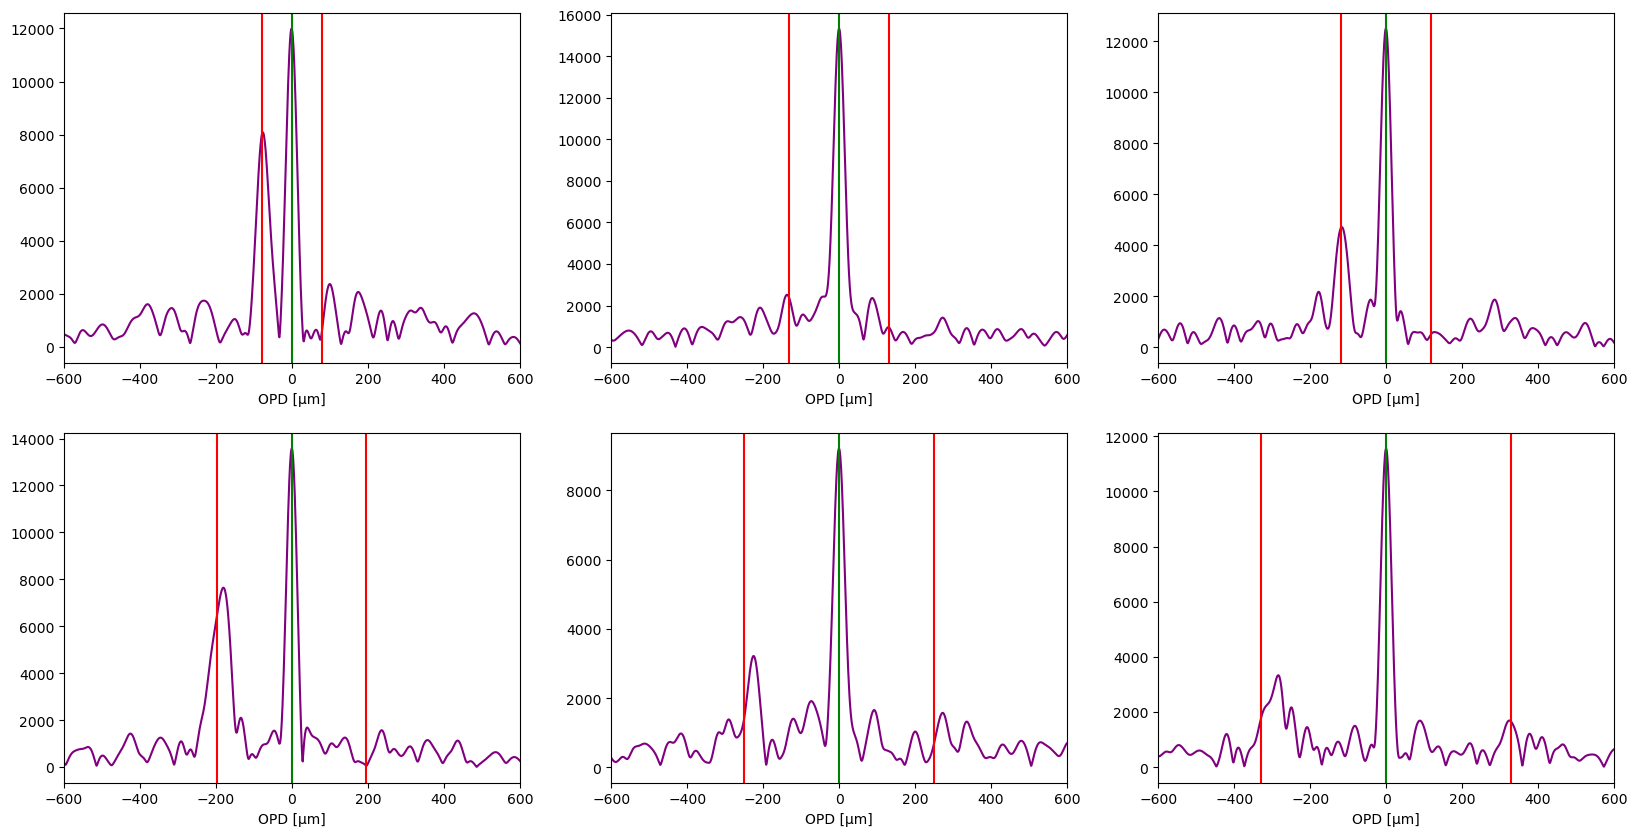

In [7]:
############ Sans addition sur les frames ############

# #HR8799e
offset_RA = -223.8
offset_Dec = 332.1
R = 0.0006973200286560031 
contrast = 0.00015306216294306115 
path = '/store/projects/MATISSE/jscigliuto/HR8799e_frames_concatenated/2023-10-31T003932_OB2_exp6_planet.fits'


#Beta Pic b 
# offset_RA = 281.6
# offset_Dec = 452.8
# R = 0.0017664150216057275
# contrast = 0.0007914035074073295
# path = '/store/projects/MATISSE/jscigliuto/betapicb_frames_corrected/2022-11-09T053024_OB2_exp3_frame5_planet_bin.fits'

def mas2rad(x):
    return x * (pi/180) * (1/3600000)

def det_OPD(offset_RA, offset_Dec, path, contrast, plot = True):
    
    hdul = fits.open(path)
    OPD_inst_lst = []

    #Baselines & coords 
    baselines = ['U1-U2', 'U1-U3', 'U1-U4', 'U2-U3', 'U2-U4', 'U3-U4']
    u = hdul['OI_VIS'].data['ucoord']
    v = hdul['OI_VIS'].data['vcoord']

    #Correlated flux    
    corrFlux_phi = hdul['OI_VIS'].data['VISPHI']
    corrFlux_amp = hdul['OI_VIS'].data['VISAMP']

    #Wavelength + mask in L-band
    lam = hdul['OI_WAVELENGTH'].data['EFF_WAVE']
    lam_mask = (lam >= 3.1e-6) & (lam <= 3.9e-6)
    lam = lam[lam_mask]


    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(20,10))
        ax_flatten = ax.flatten()

    for k in range(len(u)):        

        #Correlated flux in L-band
        corrFlux_comp = corrFlux_amp[:,lam_mask] * np.exp(1j*corrFlux_phi[:,lam_mask]*pi/180)

        #Linear interpolation in wavenumber sigma
        sigma = 1.0/lam
        sigma = sigma[::-1]
        step = np.min(np.abs(np.diff(sigma)))
        sigma_lin = np.arange(min(sigma), max(sigma), step)

        #Interpolation of correlated flux 
        f = interpolate.interp1d(sigma, corrFlux_comp.real[k])
        corrFlux_real_interp = f(sigma_lin)
        f = interpolate.interp1d(sigma, corrFlux_comp.imag[k])
        corrFlux_imag_interp = f(sigma_lin)

        corrFlux_comp = corrFlux_real_interp + 1j * corrFlux_imag_interp
        print(corrFlux_comp.shape)
        
        #Apodisation
        #corrFlux_comp -= np.mean(corrFlux_comp) 
        
            #Cosinus
        # sigma_max = 1.0 / np.min(lam)
        # sigma_min = 1.0 / np.max(lam)
        # apod = 0.5*np.cos(2 * np.pi * (sigma_lin - sigma_min) / (sigma_max - sigma_min) + pi)+0.5
        # corrFlux_comp -= np.mean(corrFlux_comp)
        # corrFlux_comp *= apod
        # print(corrFlux_comp.shape)

            #Hamming
        # corrFlux_comp *= hamming(corrFlux_comp.size)
            #Hanning
        corrFlux_comp *= np.hanning(corrFlux_comp.size)
            #Blackman
        # corrFlux_comp *= blackman(corrFlux_comp.size)
            #Kaiser
        # N = corrFlux_comp.size
        # beta = 5                  # Kaiser window parameter
        # apod = np.kaiser(N, beta)
        # corrFlux_comp *= apod
            #Bartlett 
        #corrFlux_comp *= np.bartlett(corrFlux_comp.size)

        #plt.plot(sigma_lin, apod, 'blue')
        #plt.plot(sigma_lin, corrFlux_comp, 'red')
        #plt.plot(sigma_lin, corrFlux_comp/apod, 'green')
        #plt.show()
        
        # Zero-padding
        log_base_2 = int(math.log2(corrFlux_comp.size)) 
        new_size = 2**(log_base_2+4)
        print(new_size)
        corrFlux_comp = np.pad(corrFlux_comp, (new_size - corrFlux_comp.size)//2, mode='constant', constant_values=0)

        #plt.plot(corrFlux_comp)
        #plt.show()

        #TF
        ft_phi = np.fft.fftshift(np.fft.fft(corrFlux_comp))
        OPD = np.fft.fftshift(np.fft.fftfreq(new_size, step)) * 1e6 

        #OPD determination
        OPD_inst = OPD[np.argmax(np.abs(ft_phi))] 
        OPD_inst_lst.append(OPD_inst)

        #wavelength mask's TF
        sinc = np.abs(ft_phi[np.argmax(np.abs(ft_phi))]) * np.sinc((np.max(lam) - np.min(lam))*(OPD-OPD_inst)*1e6/pi)

        if plot:
            ax_flatten[k].plot(OPD, np.sqrt(ft_phi.real**2 + ft_phi.imag**2), 'purple')
            ax_flatten[k].set_xlabel('OPD [µm]')
            #ax_flatten[k].axvline((offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(OPD_inst, color='green')
            ax_flatten[k].axvline(OPD_inst+(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(OPD_inst-(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            #ax_flatten[k].plot(OPD, sinc, 'orange')
            #ax_flatten[k].set_yscale('log')
            ax_flatten[k].set_xlim(-600, 600)

    return OPD_inst_lst

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

OPD_inst = det_OPD(offset_RA, offset_Dec, path, contrast, plot = True)
print(OPD_inst)


[[272.43388983 275.78944214 275.8088082  ... 242.0405626  255.62121417
  265.75034574]
 [287.52670799 298.74653648 306.89409669 ... 253.76885698 262.69065815
  274.61725944]
 [183.09522468 190.10137193 195.30928155 ... 137.49277613 159.93598842
  173.58990304]
 [245.88144695 242.21454755 243.74056755 ... 240.44461775 245.56729994
  247.50111746]
 [198.13069041 194.58171308 190.22532712 ... 209.37593091 205.62341409
  201.66362655]
 [227.19414617 228.3236136  228.41060776 ... 204.3837071  218.39197466
  224.38422801]]


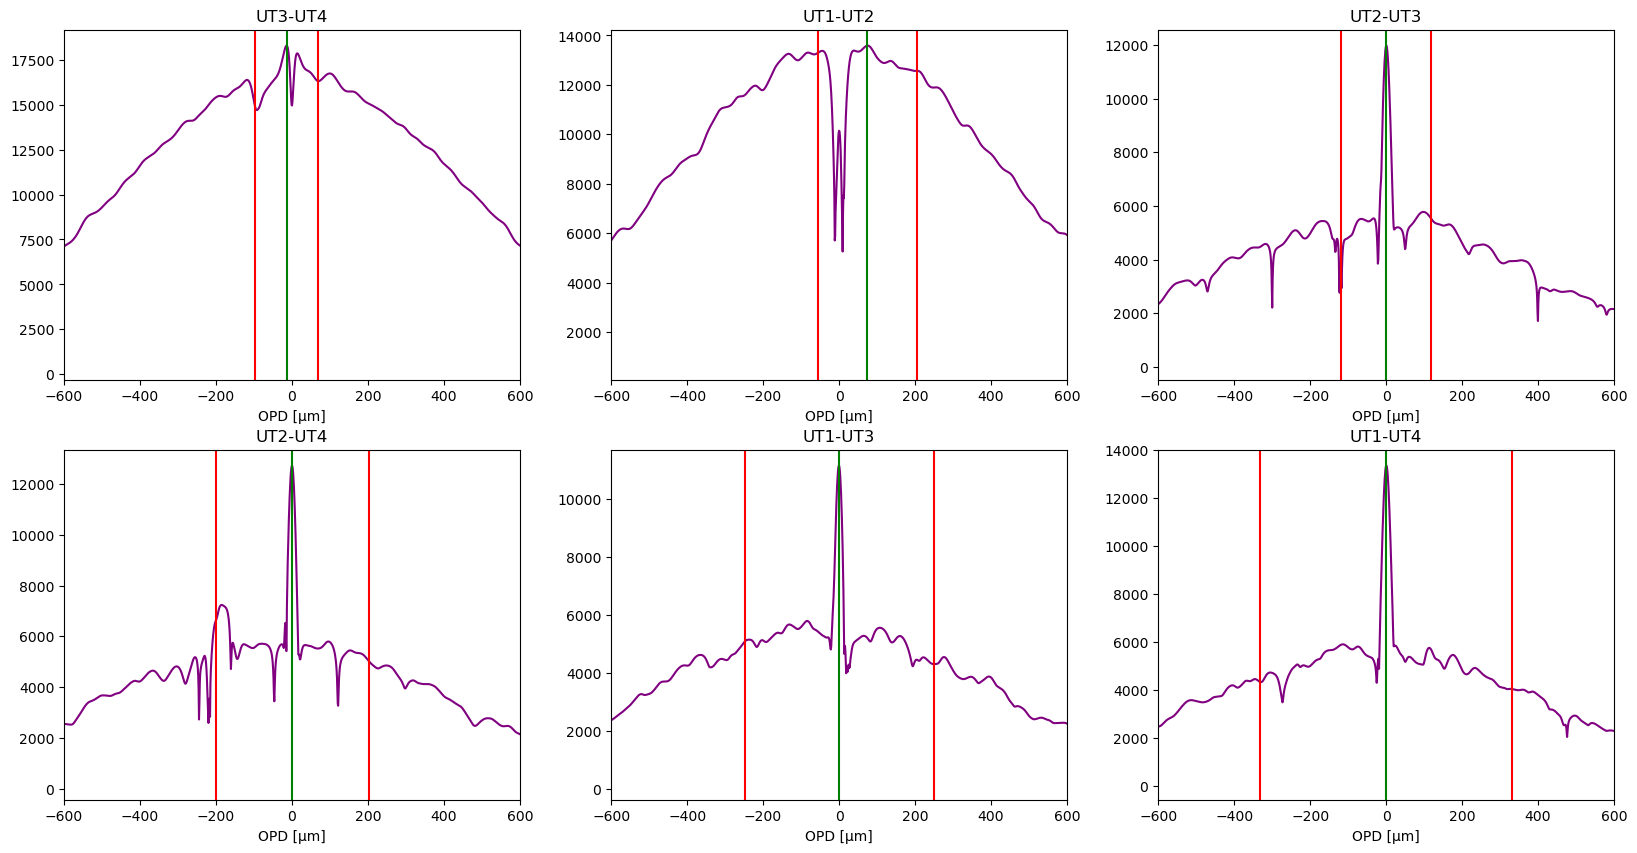

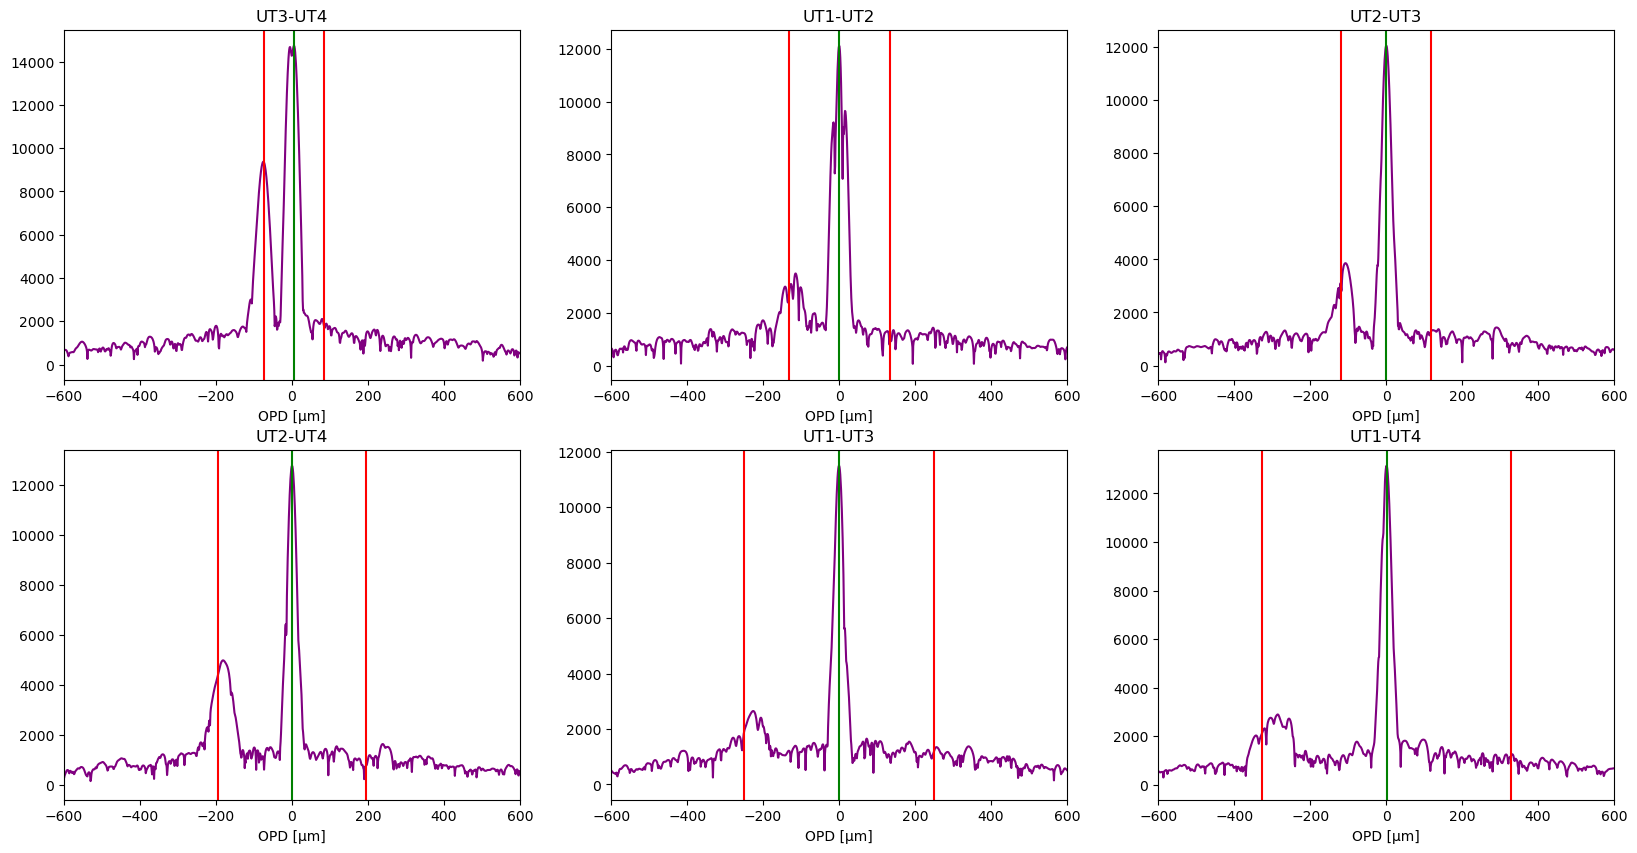

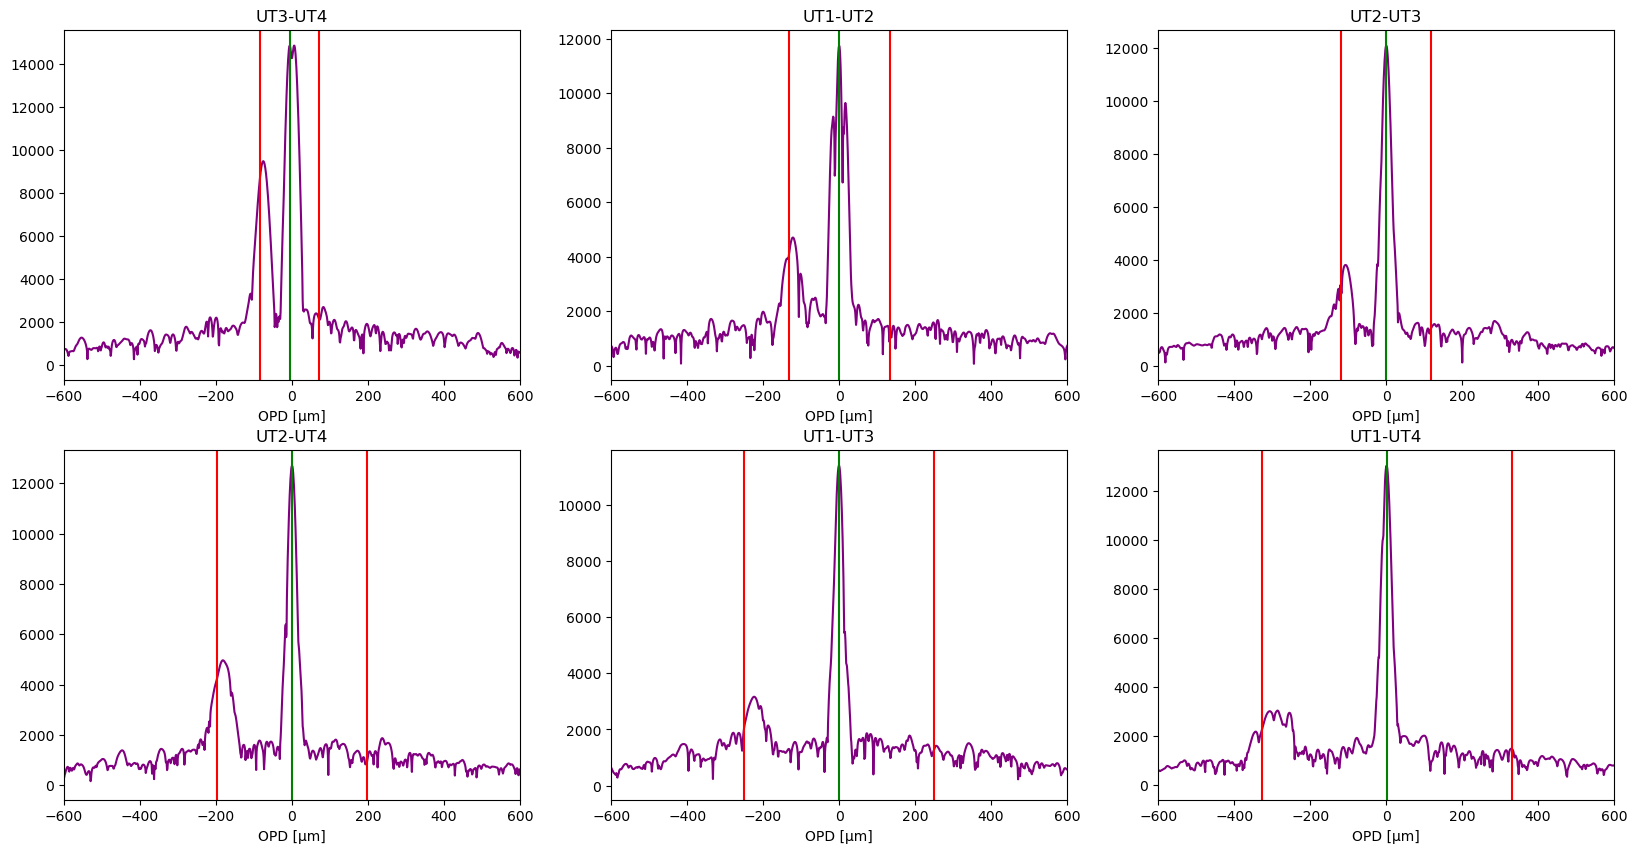

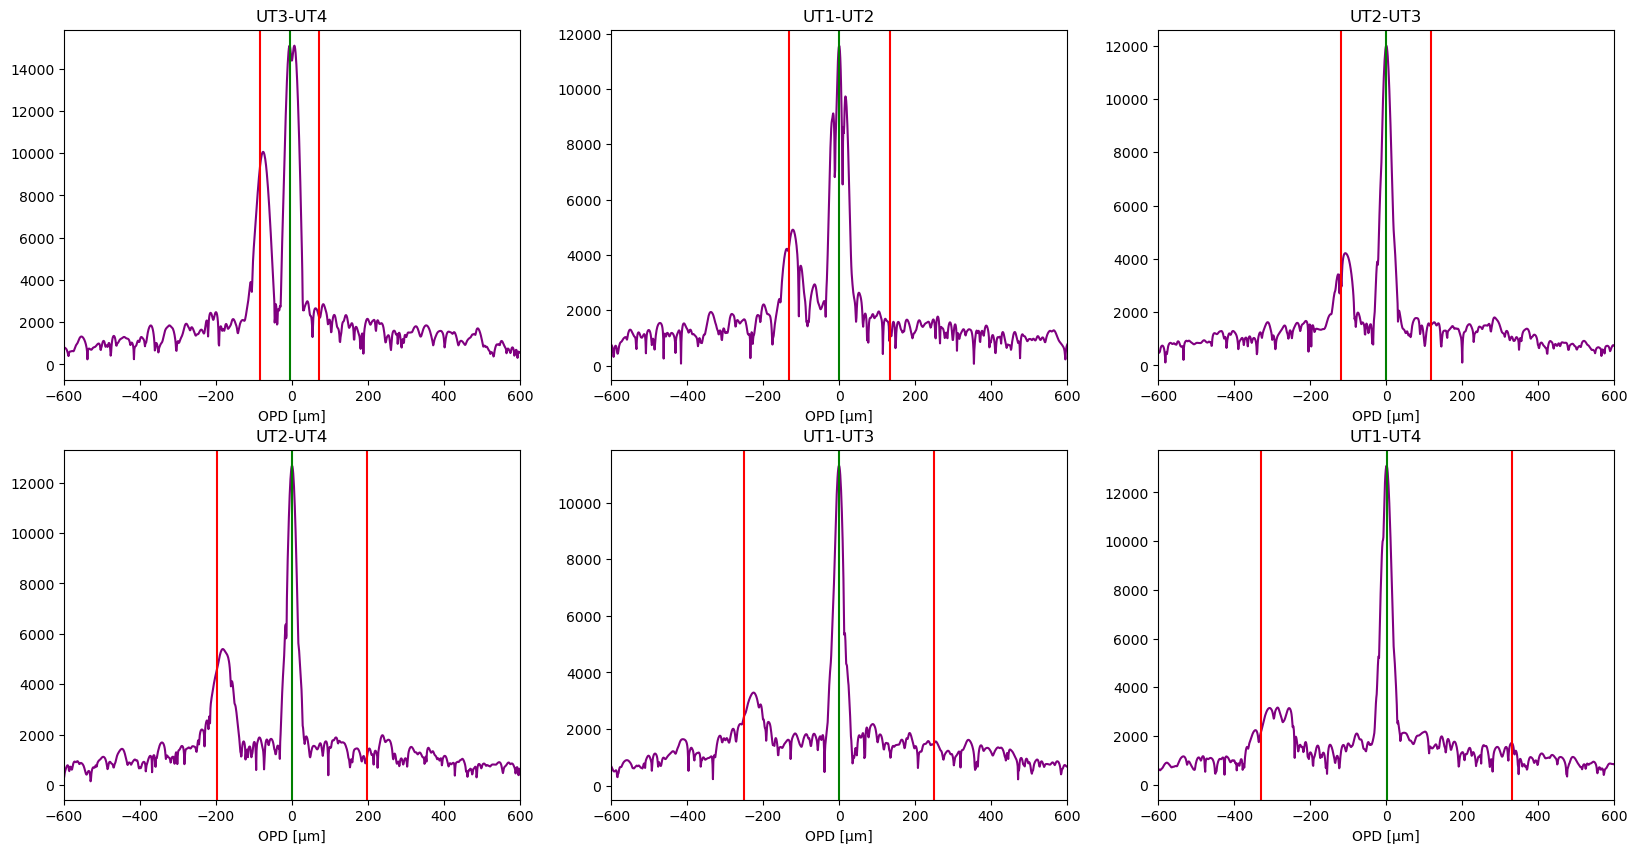

In [4]:
############ Avec addition sur les frames ############

# #HR8799e
# offset_RA = -223.8
# offset_Dec = 332.1
# R = 0.0006973200286560031 
# contrast = 0.00015306216294306115 
# path = '/store/projects/MATISSE/jscigliuto/HR8799e_frames_concatenated/2023-10-31T003932_OB2_exp6_planet.fits'
# path_frames  = '/store/projects/MATISSE/jscigliuto/HR8799e_frames/frames'

#Beta Pic b 
offset_RA = 281.6
offset_Dec = 452.8
R = 0.0017664150216057275
contrast = 0.0007914035074073295
path_frames = '/store/projects/MATISSE/jscigliuto/betapicb_frames_corrected/'

def mas2rad(x):
    return x * (pi/180) * (1/3600000)

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

#Baselines names
baselines_order = ['UT3-UT4', 'UT1-UT2', 'UT2-UT3', 'UT2-UT4', 'UT1-UT3', 'UT1-UT4']

#Planet frames
files_planet = sorted(glob.glob(path_frames + '/*_planet*'))
OB_list = sorted(set([file[file.find('OB')+2:file.find('_exp')] for file in files_planet]))
exp_list = sorted(set([file[file.find('exp')+3:file.find('_planet')] for file in files_planet]))
n_exp = len(exp_list)
n_files = len(files_planet)
n_OB = len(OB_list)

#Initialization
OPD_inst_list = []


for i_OB in range(n_OB):
    
    files_OB = sorted([file for file in files_planet if f'OB{OB_list[i_OB]}' in file])
    n_frames = len(files_OB)
    files_exp = sorted([file for file in files_OB if f'exp{exp_list[i_OB]}' in file])
    n_exp = len(files_exp)

   # cf_OB = np.zeros((n_frames, 6, 8192))
    cf_OB = np.zeros((n_frames, 6, 2048))

    for i_frames in range(n_frames): 

        # Extract quantities 
        hdul = fits.open(files_planet[i_frames]) 
        lam = hdul['OI_WAVELENGTH'].data['EFF_WAVE']
        lam_mask = (lam >= 3.1e-6) & (lam <= 3.9e-6)
        lam = lam[lam_mask]
        u = hdul['OI_VIS'].data['ucoord']
        v = hdul['OI_VIS'].data['vcoord']
        corrFlux_phi = hdul['OI_VIS'].data['VISPHI']
        corrFlux_amp = hdul['OI_VIS'].data['VISAMP']
        #print(corrFlux_amp.shape, corrFlux_phi.shape)

        for i_baselines in range(6):
            
            #Correlated flux in L-band
            corrFlux_comp = corrFlux_amp[i_baselines,lam_mask] * np.exp(1j*corrFlux_phi[i_baselines,lam_mask]*pi/180)

            #Linear interpolation in wavenumber sigma
            sigma = 1.0/lam
            sigma = sigma[::-1]
            step = np.min(np.abs(np.diff(sigma)))
            sigma_lin = np.arange(min(sigma), max(sigma), step)

            #Interpolation of correlated flux 
            f = interpolate.interp1d(sigma, corrFlux_comp.real)
            corrFlux_real_interp = f(sigma_lin)
            f = interpolate.interp1d(sigma, corrFlux_comp.imag)
            corrFlux_imag_interp = f(sigma_lin)

            corrFlux_comp = corrFlux_real_interp + 1j * corrFlux_imag_interp
            
            # Apodisation
            # Hanning
            corrFlux_comp *= np.hanning(corrFlux_comp.size)
            
            # Zero-padding
            log_base_2 = int(math.log2(corrFlux_comp.size)) 
            new_size = 2**(log_base_2+4)
            corrFlux_comp = np.pad(corrFlux_comp, (new_size - corrFlux_comp.size)//2, mode='constant', constant_values=0)

            #TF
            ft_cf = np.fft.fftshift(np.fft.fft(corrFlux_comp))
            OPD = np.fft.fftshift(np.fft.fftfreq(new_size, step)) * 1e6 
            module = np.abs(ft_cf)

            cf_OB[i_frames, i_baselines] = module 

            # Wavelength mask's TF
            #sinc = np.abs(ft_cf[np.argmax(np.abs(ft_cf))]) * np.sinc((np.max(lam) - np.min(lam))*(OPD-OPD_inst)*1e6/pi)
    
    # Sum over frames
            
    #cf_OB_sum = np.sum(cf_OB, axis = 0) 
    #cf_OB_sum = gmean(cf_OB, axis=0)
    #cf_OB_sum = np.sqrt(np.mean(np.square(cf_OB), axis=0))
    cf_OB_sum = hmean(cf_OB, axis=0)
    #cf_OB_sum = scipy.stats.gmean(cf_OB, axis=0)

    fig, ax = plt.subplots(2, 3, figsize=(20,10))
    ax_flat = ax.flat 
    
    for i_baselines in range(6):

        # OPD determination
        OPD_inst = OPD[np.argmax(cf_OB_sum[i_baselines,:])] 
        OPD_inst_list.append(OPD_inst)

        # Plots
        ax_flat[i_baselines].plot(OPD, cf_OB_sum[i_baselines,:], 'purple')
        ax_flat[i_baselines].set_xlabel('OPD [µm]')
        #ax_flat[k].axvline((offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
        ax_flat[i_baselines].axvline(OPD_inst, color='green')
        ax_flat[i_baselines].axvline(OPD_inst+(offset_RA*u[i_baselines]+offset_Dec*v[i_baselines])*1e6, color='red')
        ax_flat[i_baselines].axvline(OPD_inst-(offset_RA*u[i_baselines]+offset_Dec*v[i_baselines])*1e6, color='red')
        ax_flat[i_baselines].set_title(f'{baselines_order[i_baselines]}')
        #ax_flat[k].plot(OPD, sinc, 'orange')
        #ax_flat[k].set_yscale('log')
        ax_flat[i_baselines].set_xlim(-600, 600)

        # Save the figure
        fig.savefig(f'figure_{i_OB}.png')

print(cf_OB_sum)



[[[28983.44865045 28940.6637087  28914.34338475 ... 29218.68886098
   29121.15603927 29043.27579044]
  [28984.24840305 28937.65088272 28893.58050413 ... 29139.07680849
   29084.84729217 29033.29835851]
  [14898.99133398 14838.70775425 14764.82134515 ... 15008.92999433
   14982.67963995 14946.55809018]
  [14157.86390849 14035.93265349 13939.0982193  ... 14568.71745607
   14430.12733786 14292.19440711]
  [13788.90347316 13744.87356985 13699.95519149 ... 13916.0941634
   13874.27558801 13831.9936226 ]
  [14702.91889852 14677.14082806 14636.24457108 ... 14700.58786283
   14712.09761438 14714.16670035]]

 [[36829.95246454 36831.26263379 36843.33809154 ... 36911.5122396
   36867.41903762 36841.22528356]
  [36146.84286473 36034.942365   35923.22403759 ... 36485.05600523
   36371.82953957 36259.08567462]
  [22536.6091977  22491.57452035 22430.13430632 ... 22603.17098465
   22587.57028108 22567.40255958]
  [21579.70992122 21572.94645661 21578.82483806 ... 21631.10479704
   21606.14386568 21590.

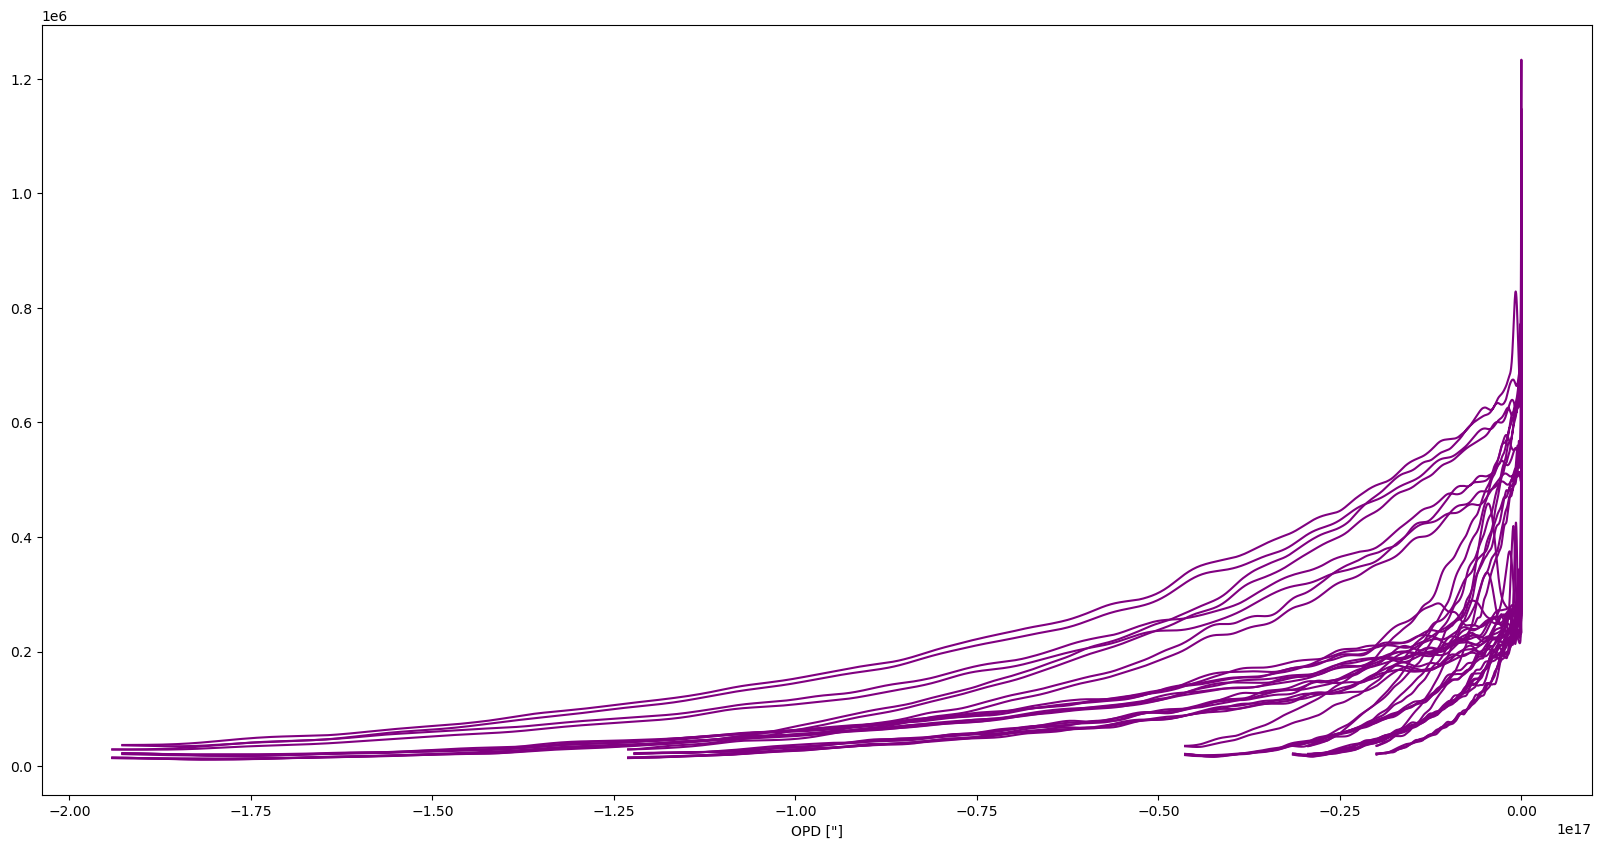

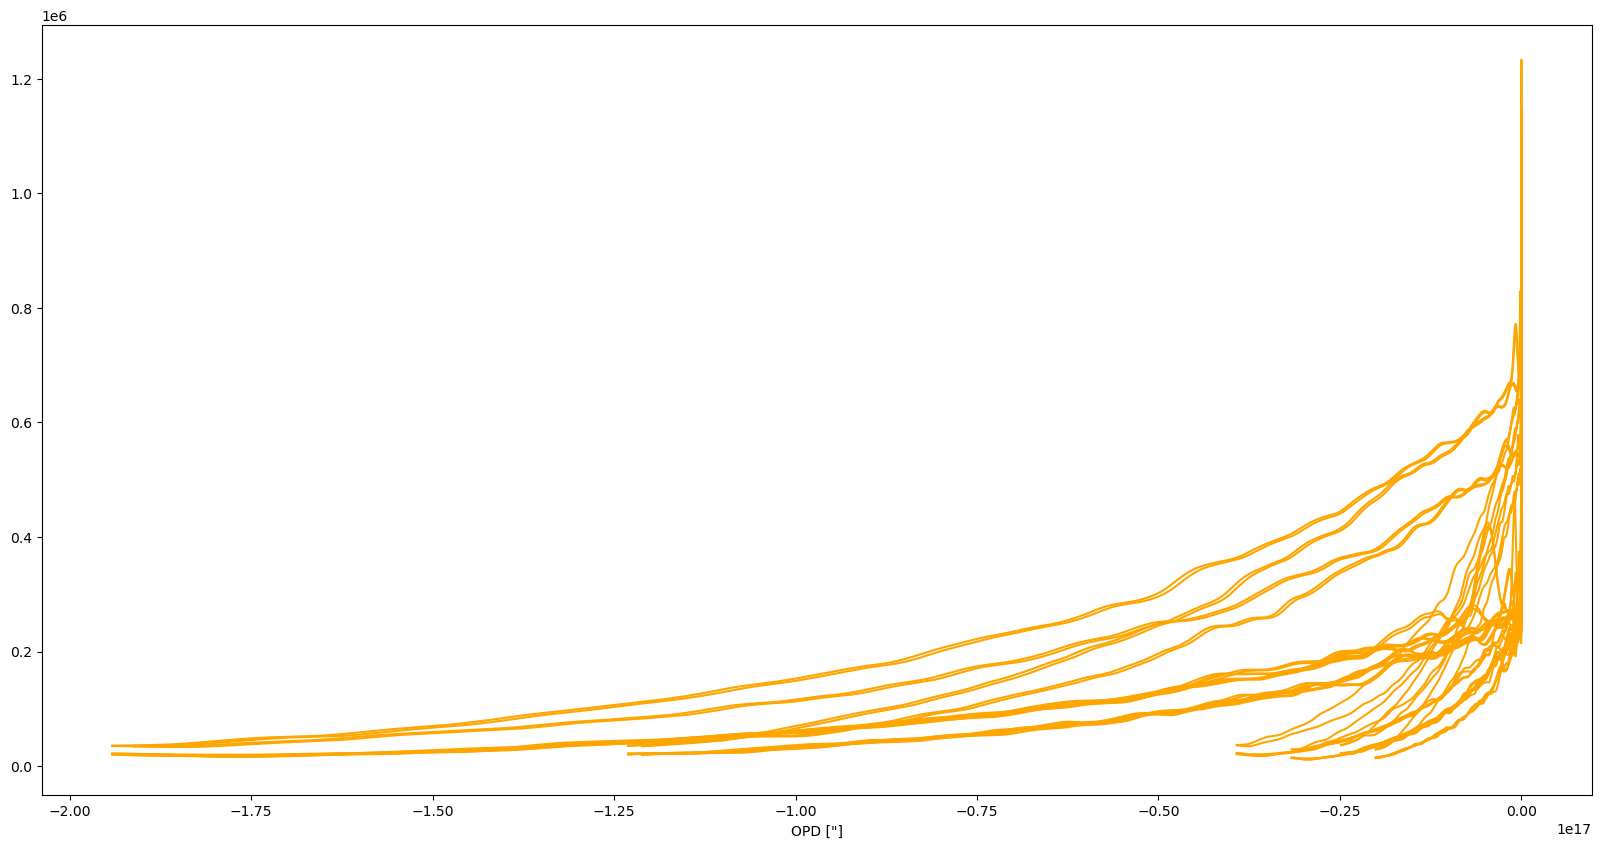

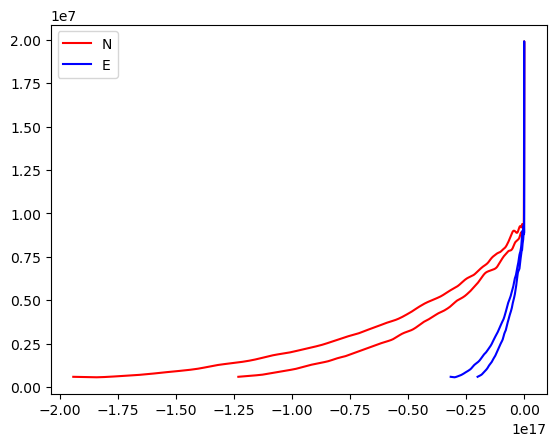

In [81]:
############ Avec addition sur les frames + Astrométrie ############



# #HR8799e
# offset_RA = -223.8
# offset_Dec = 332.1
# R = 0.0006973200286560031 
# contrast = 0.00015306216294306115 
# path = '/store/projects/MATISSE/jscigliuto/HR8799e_frames_concatenated/2023-10-31T003932_OB2_exp6_planet.fits'
# path_frames  = '/store/projects/MATISSE/jscigliuto/HR8799e_frames/frames'

#Beta Pic b 
offset_RA = 281.6
offset_Dec = 452.8
R = 0.0017664150216057275
contrast = 0.0007914035074073295
path_frames = '/store/projects/MATISSE/jscigliuto/betapicb_frames_corrected/'

def mas2rad(x):
    return x * (pi/180) * (1/3600000)

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

#Baselines names
baselines_order = ['UT3-UT4', 'UT1-UT2', 'UT2-UT3', 'UT2-UT4', 'UT1-UT3', 'UT1-UT4']

#Planet frames
files_planet = sorted(glob.glob(path_frames + '/*_planet*'))
OB_list = sorted(set([int(file[file.find('OB')+2:file.find('_exp')]) for file in files_planet]))
exp_list = sorted(set([file[file.find('exp')+3:file.find('_planet')] for file in files_planet]))
n_exp = len(exp_list)
n_files = len(files_planet)
n_OB = len(OB_list)

#Initialization
OPD_inst_list = []
cf_OB_saved = []
OPD_OB_N = {}
OPD_OB_E = {}
fig, ax1 = plt.subplots(1, 1, figsize=(20,10))
fig, ax2 = plt.subplots(1, 1, figsize=(20,10))

for i_OB in range(n_OB):
    
    files_OB = sorted([file for file in files_planet if f'OB{OB_list[i_OB]}' in file])
    n_frames = len(files_OB)
    files_exp = sorted([file for file in files_OB if f'exp{exp_list[i_OB]}' in file])
    n_exp = len(files_exp)

   # cf_OB = np.zeros((n_frames, 6, 8192))
    cf_OB = np.zeros((n_frames, 6, 2048))

    for i_frames in range(n_frames): 

        # Extract quantities 
        hdul = fits.open(files_planet[i_frames]) 
        lam = hdul['OI_WAVELENGTH'].data['EFF_WAVE']
        lam_mask = (lam >= 3.1e-6) & (lam <= 3.9e-6)
        lam = lam[lam_mask]
        u = hdul['OI_VIS'].data['ucoord']
        v = hdul['OI_VIS'].data['vcoord']
        corrFlux_phi = hdul['OI_VIS'].data['VISPHI']
        corrFlux_amp = hdul['OI_VIS'].data['VISAMP']
        #print(corrFlux_amp.shape, corrFlux_phi.shape)

        for i_baselines in range(6):
            
            #Correlated flux in L-band
            corrFlux_comp = corrFlux_amp[i_baselines,lam_mask] * np.exp(1j*corrFlux_phi[i_baselines,lam_mask]*pi/180)

            #Linear interpolation in wavenumber sigma
            sigma = 1.0/lam
            sigma = sigma[::-1]
            step = np.min(np.abs(np.diff(sigma)))
            sigma_lin = np.arange(min(sigma), max(sigma), step)

            #Interpolation of correlated flux 
            f = interpolate.interp1d(sigma, corrFlux_comp.real)
            corrFlux_real_interp = f(sigma_lin)
            f = interpolate.interp1d(sigma, corrFlux_comp.imag)
            corrFlux_imag_interp = f(sigma_lin)

            corrFlux_comp = corrFlux_real_interp + 1j * corrFlux_imag_interp
            
            # Apodisation
            # Hanning
            corrFlux_comp *= np.hanning(corrFlux_comp.size)
            
            # Zero-padding
            log_base_2 = int(math.log2(corrFlux_comp.size)) 
            new_size = 2**(log_base_2+4)
            corrFlux_comp = np.pad(corrFlux_comp, (new_size - corrFlux_comp.size)//2, mode='constant', constant_values=0)

            #TF
            ft_cf = np.fft.fftshift(np.fft.fft(corrFlux_comp))
            OPD = np.fft.fftshift(np.fft.fftfreq(new_size, step)) * 1e6
            module = np.abs(ft_cf)

            cf_OB[i_frames, i_baselines] = module 

    # Sum over frames
    cf_OB_sum = np.sum(cf_OB, axis = 0)  
    cf_OB_saved.append(cf_OB_sum)
    #cf_OB_sum = np.sqrt(np.mean(np.square(cf_OB), axis=0))
    #cf_OB_sum = hmean(cf_OB, axis=0)
    #cf_OB_sum = scipy.stats.gmean(cf_OB, axis=0)

    #OPD --> arcsec on sky
    step_lam = (max(lam)-min(lam)) / OPD.size
    lam_sampled = np.arange(min(lam), max(lam), step_lam) * 1e6
    OPD *= ((3600 * 180 * 2 * pi) / (pi * lam_sampled)) #arcsec

    theta_uv = np.arctan(u/v) * ((3600 * 180) / pi) #arcsec

    for i_baselines, theta in enumerate(theta_uv):

        #Deprojection along the baselines direction
        OPD_N = OPD * np.cos(theta)
        OPD_E = OPD * np.sin(theta)

        OPD_OB_N[OB_list[i_OB]] = [OPD*OPD_N]
        OPD_OB_E[OB_list[i_OB]] = [OPD*OPD_E]

        # OPD determination
        OPD_inst = OPD[np.argmax(cf_OB_sum[i_baselines,:])] 
        OPD_inst_list.append(OPD_inst)

    #Plots
    for i_baselines in range(6):

        ax1.plot(np.squeeze(OPD_OB_N[OB_list[i_OB]]), cf_OB_saved[i_OB][i_baselines,:], 'purple')
        ax2.plot(np.squeeze(OPD_OB_E[OB_list[i_OB]]), cf_OB_saved[i_OB][i_baselines,:], 'orange')
        ax1.set_xlabel('OPD ["]')
        ax2.set_xlabel('OPD ["]')
        # ax1.set_xlim(-0.15*1e17, 0)
        # ax2.set_xlim(-0.15*1e17, 0)

        # Save the figure
        fig.savefig(f'figure_{i_OB}.png')

cf_OB_saved = np.squeeze(cf_OB_saved)
print(cf_OB_saved)
cf_OB_sum_all = np.sum(cf_OB_saved, axis=0)
cf_OB_sum_all = np.sum(cf_OB_sum_all, axis=0)

plt.figure()
plt.plot(np.squeeze(OPD_OB_N[1]), cf_OB_sum_all, 'red', label='N')
plt.plot(np.squeeze(OPD_OB_E[1]), cf_OB_sum_all, 'blue', label='E')
plt.legend()
#plt.xlim(-0*1e16, 0.005*1e16)
plt.show()



[53.96397598398938,
 -26.98198799199469,
 -8.993995997331563,
 53.96397598398938,
 -26.98198799199469,
 35.97598398932625]

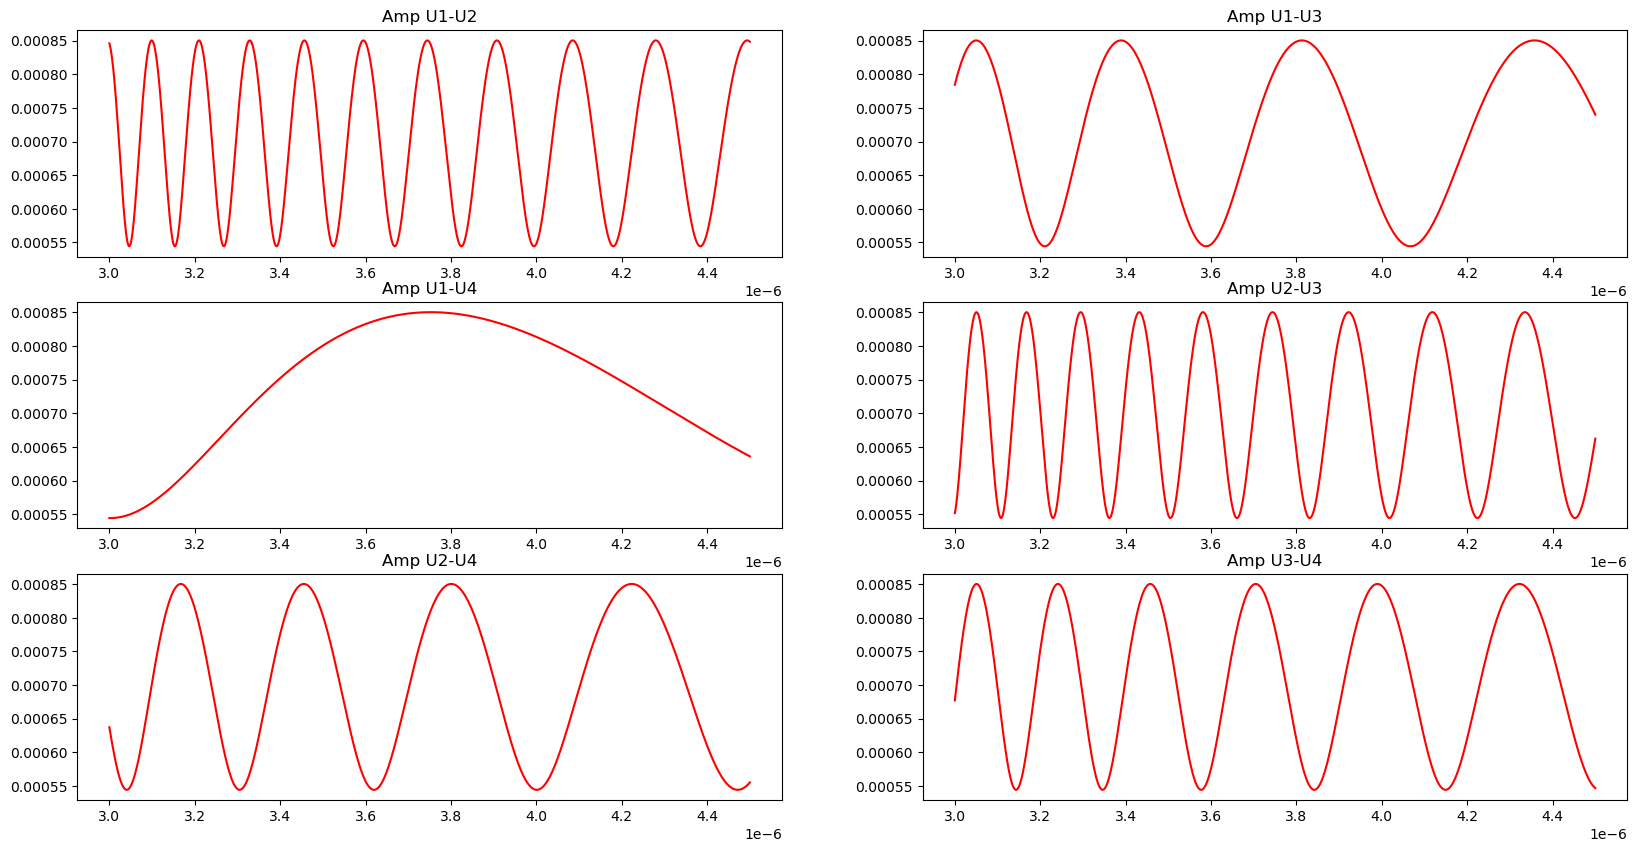

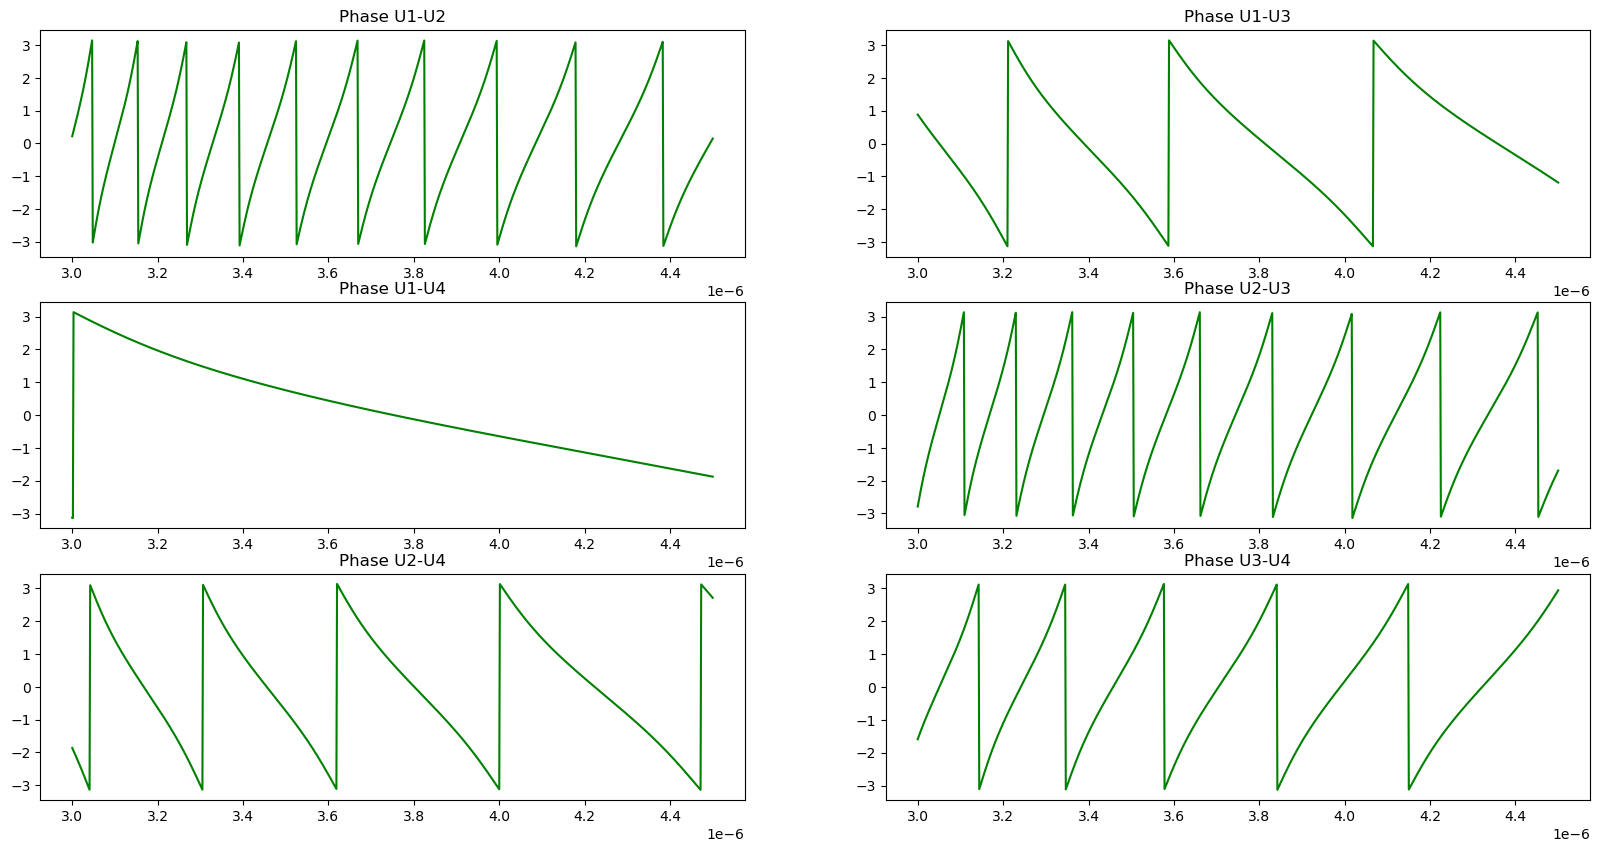

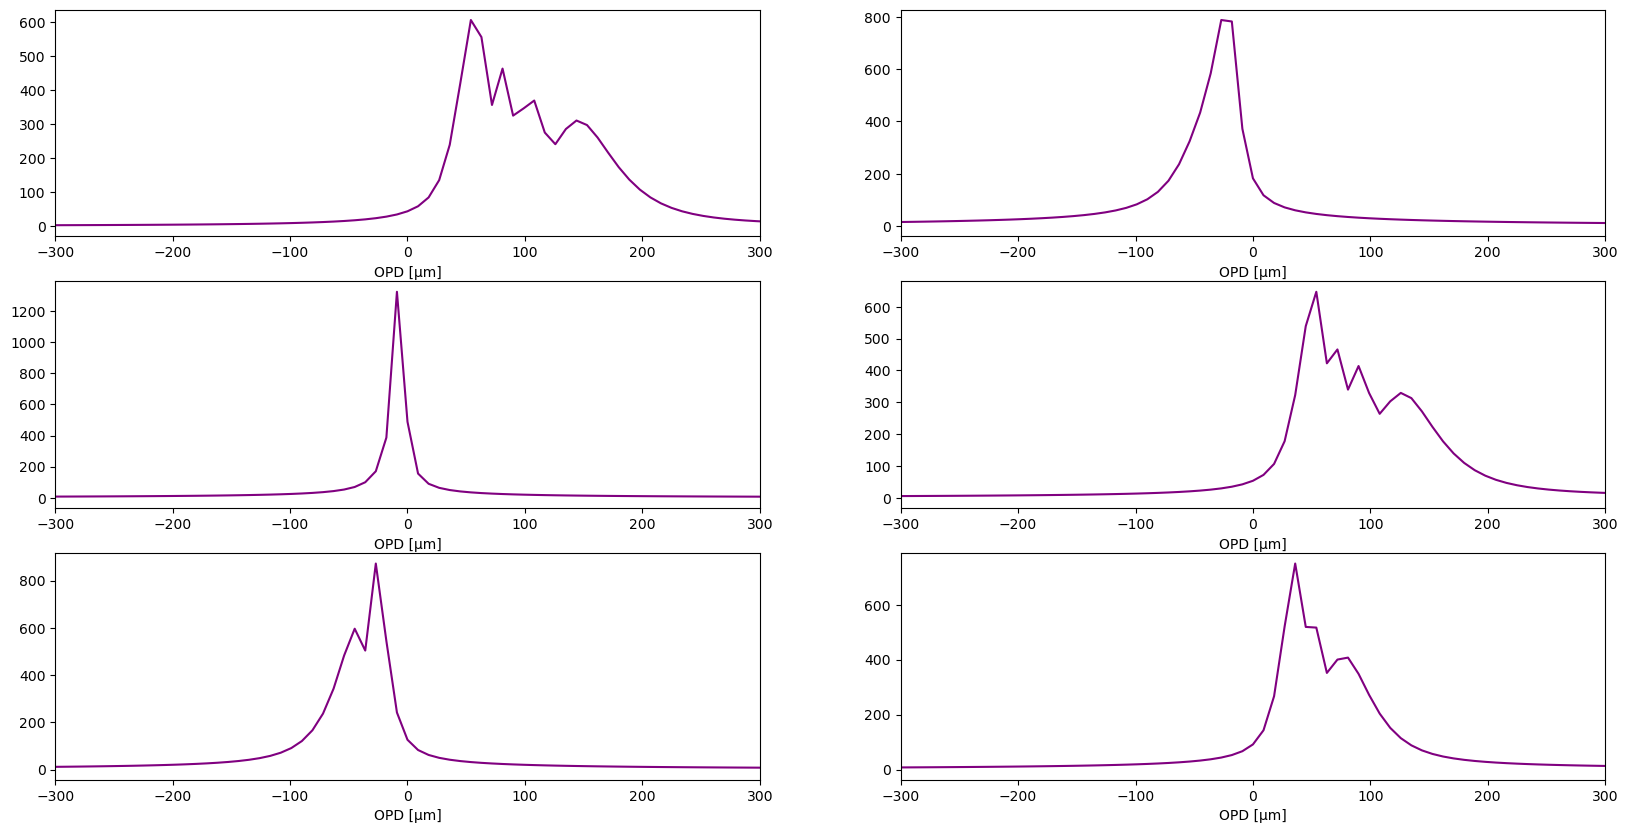

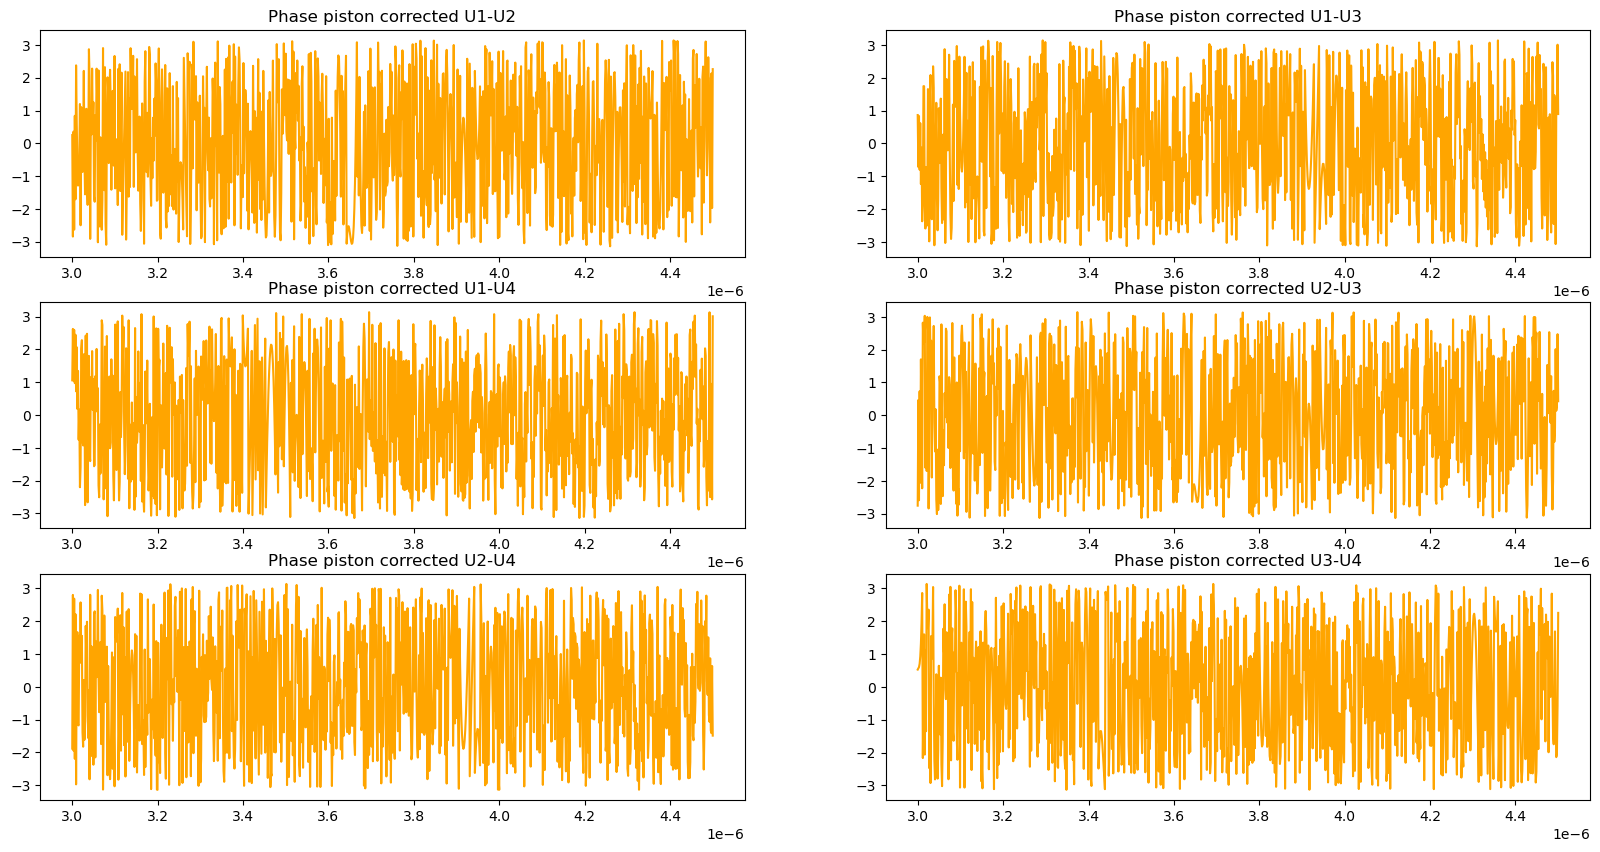

In [75]:
#HR8799e
offset_RA = -223.8
offset_Dec = 332.1
R = 0.0006973200286560031 
contrast = 0.00015306216294306115 
path = '/store/projects/MATISSE/jscigliuto/HR8799e_phase_corrected/corrected_data/2023-10-31T010342_OB2_exp22_frame4_planet.fits'

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

def det_OPD_simu(offset_RA, offset_Dec, path, contrast, plot = True):
    
    piston_lst = []
    hdul = fits.open(path)

    #Baselines & coords
    baselines = ['U1-U2', 'U1-U3', 'U1-U4', 'U2-U3', 'U2-U4', 'U3-U4']
    u = hdul['OI_VIS'].data['ucoord']
    v = hdul['OI_VIS'].data['vcoord']

    #Wavelength
    lam = np.linspace(3, 4.5, 1000, endpoint=True) * 1e-6

    if plot:
        fig, ax = plt.subplots(3, 2, figsize=(20,10))
        ax_flatten = ax.flatten()
            
        fig, ax1 = plt.subplots(3, 2, figsize=(20,10))
        ax1_flatten = ax1.flatten()

        fig, ax2 = plt.subplots(3, 2, figsize=(20,10))
        ax2_flatten = ax2.flatten()

        fig, ax3 = plt.subplots(3, 2, figsize=(20,10))
        ax3_flatten = ax3.flatten()

    for k in range(len(u)):   

        #Correlated flux     
        corrFlux = contrast + R*np.exp(2j * pi * (offset_RA*u[k] + offset_Dec*v[k]) / lam)

        #Module & phase
        phi = np.angle(corrFlux)
        module = np.abs(corrFlux)

        #Correlated flux, module = 1 to remove the modulations on the oscillations
        corrFlux1 = np.exp(2j * pi * (offset_RA*u[k] + offset_Dec*v[k]) / lam)

        #Linear interpolation in wavenumber sigma
        sigma = 1.0/lam
        sigma = sigma[::-1]
        step = np.min(np.abs(np.diff(sigma)))
        sigma_lin = np.arange(min(sigma), max(sigma), step)

        #Interpolation of correlated flux
        f = interpolate.interp1d(sigma, corrFlux1.real)
        corrFlux_real_interp = f(sigma_lin)
        f = interpolate.interp1d(sigma, corrFlux1.imag)
        corrFlux_imag_interp = f(sigma_lin)

        corrFlux_interp = corrFlux_real_interp + 1j * corrFlux_imag_interp

        #TF
        ft_phi = np.fft.fftshift(np.fft.fft(corrFlux_interp))
        OPD = np.fft.fftshift(np.fft.fftfreq(sigma_lin.size, step)) * 1e6

        #OPD determination
        piston = OPD[np.argmax(np.abs(ft_phi))] 
        piston_lst.append(piston)

        #OPD correction
        phi_piston_corrected = np.exp(1j * phi) * np.exp(-2j * pi * piston / lam )
        
        if plot:
            ax_flatten[k].plot(lam, module, 'red')
            ax_flatten[k].set_title(f'Amp {baselines[k]}')

            ax1_flatten[k].plot(lam, phi, 'green')
            ax1_flatten[k].set_title(f'Phase {baselines[k]}')
            
            ax2_flatten[k].plot(OPD, np.abs(ft_phi), 'purple')
            ax2_flatten[k].set_xlabel('OPD [µm]')
            ax2_flatten[k].set_xlim(-300, 300)

            ax3_flatten[k].plot(lam, np.angle(phi_piston_corrected), 'orange')
            ax3_flatten[k].set_title(f'Phase piston corrected {baselines[k]}')
    
    return piston_lst

det_OPD_simu(offset_RA, offset_Dec, path, contrast, plot = True)


(704,)
(704,)
8192
(704,)
(704,)
8192
(704,)
(704,)
8192
(704,)
(704,)
8192
(704,)
(704,)
8192
(704,)
(704,)
8192
[107.87377083008313, 118.27124271732006, 250.83900927959087, 76.68135516837233, 16.895891816760006, 54.58672740799388]


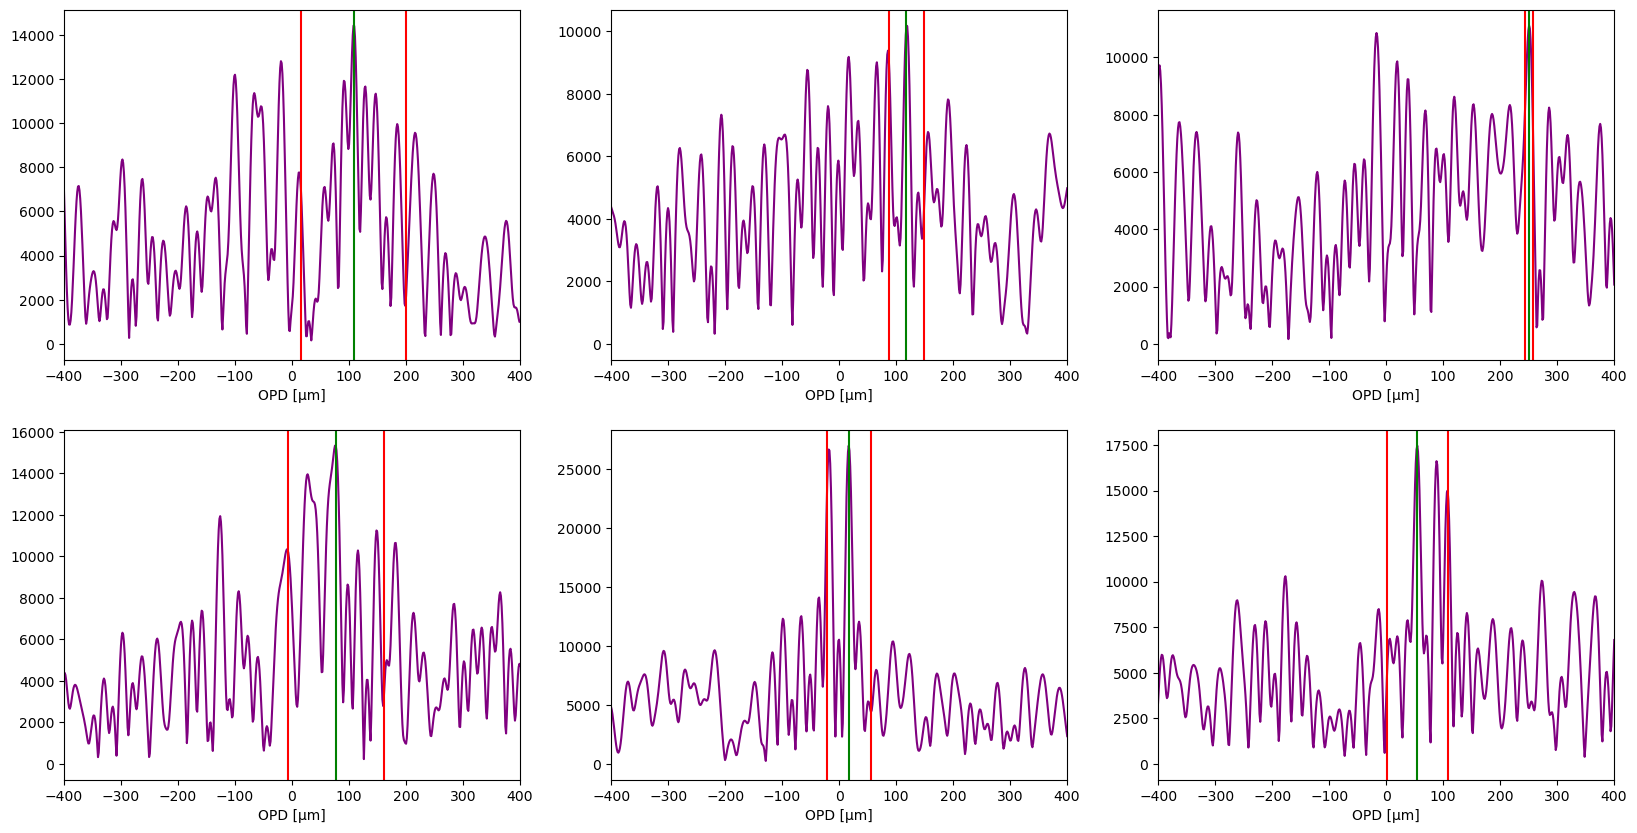

In [8]:
#lam = np.linspace(3.0, 4.5, 10001, endpoint=True)*1e-6

#HR8799e
offset_RA = -223.8
offset_Dec = 332.1
R = 0.0006973200286560031 
contrast = 0.00015306216294306115 
path = '/store/projects/MATISSE/jscigliuto/HR8799e_phase_corrected/corrected_data/2023-10-31T005004_OB2_exp13_frame5_planet.fits'

# #Beta Pic b 
# offset_RA = 281.6
# offset_Dec = 452.8
# R = 0.0017664150216057275
# contrast = 0.0007914035074073295
# path = '/store/projects/MATISSE/jscigliuto/2022-11-09T054520_OB2_exp12_frame4_planet.fits'

def mas2rad(x):
    radx = x * (pi/180) * (1/3600000)
    return radx

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

def det_OPD(offset_RA, offset_Dec, path, contrast, plot = True):
    
    hdul = fits.open(path)
    piston_lst = []

    #Baselines & coords 
    baselines = ['U1-U2', 'U1-U3', 'U1-U4', 'U2-U3', 'U2-U4', 'U3-U4']
    u = hdul['OI_VIS'].data['ucoord']
    v = hdul['OI_VIS'].data['vcoord']

    #Correlated flux    
    corrFlux_phi = hdul['OI_VIS'].data['VISPHI']
    corrFlux_amp = hdul['OI_VIS'].data['VISAMP']

    #Wavelength + mask in L-band
    lam = hdul['OI_WAVELENGTH'].data['EFF_WAVE']
    lam_mask = (lam >= 3.1e-6) & (lam <= 3.9e-6)
    lam = lam[lam_mask]


    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(20,10))
        ax_flatten = ax.flatten()

    for k in range(len(u)):        
        
        #Correlated flux in L-band
        corrFlux_comp = corrFlux_amp[:,lam_mask] * np.exp(1j*corrFlux_phi[:,lam_mask]*pi/180)

        #Linear interpolation in wavenumber sigma
        sigma = 1.0/lam
        sigma = sigma[::-1]
        step = np.min(np.abs(np.diff(sigma)))
        sigma_lin = np.arange(min(sigma), max(sigma), step)

        #Interpolation of correlated flux 
        f = interpolate.interp1d(sigma, corrFlux_comp.real[k])
        corrFlux_real_interp = f(sigma_lin)
        f = interpolate.interp1d(sigma, corrFlux_comp.imag[k])
        corrFlux_imag_interp = f(sigma_lin)

        corrFlux_comp = corrFlux_real_interp + 1j * corrFlux_imag_interp
        print(corrFlux_comp.shape)

        #Apodisation
        sigma_max = 1.0 / np.min(lam)
        sigma_min = 1.0 / np.max(lam)
        apod = np.cos(2 * np.pi * (sigma_lin - sigma_min) / (sigma_max - sigma_min))
        corrFlux_comp *= apod
        print(corrFlux_comp.shape)
        
        # Zero-padding
        log_base_2 = int(math.log2(corrFlux_comp.size)) 
        new_size = 2**(log_base_2+4)
        print(new_size)
        corrFlux_comp = np.fft.fftshift(corrFlux_comp)
        corrFlux_comp = np.pad(corrFlux_comp, (new_size - corrFlux_comp.size)//2, mode='constant', constant_values=0)

        #TF
        ft_phi = np.fft.fftshift(np.fft.fft(corrFlux_comp))
        OPD = np.fft.fftshift(np.fft.fftfreq(new_size, step)) * 1e6 

        #OPD determination
        piston = OPD[np.argmax(np.abs(ft_phi))] 
        piston_lst.append(piston)

        #wavelength mask's TF
        sinc = np.abs(ft_phi[np.argmax(np.abs(ft_phi))]) * np.sinc((np.max(lam) - np.min(lam))*(OPD-piston)*1e6/pi)

        if plot:
            ax_flatten[k].plot(OPD, np.abs(ft_phi), 'purple')
            ax_flatten[k].set_xlabel('OPD [µm]')
            #ax_flatten[k].axvline((offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(piston, color='green')
            ax_flatten[k].axvline(piston+(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(piston-(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            #ax_flatten[k].plot(OPD, sinc, 'orange')
            #ax_flatten[k].set_yscale('log')
            ax_flatten[k].set_xlim(-400, 400)

    return piston_lst

piston = det_OPD(offset_RA, offset_Dec, path, contrast, plot = True)
print(piston)
